In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [3]:
df = pd.read_csv("fraudTest.csv", on_bad_lines="skip")
df = df[0:255719]
print(df.shape)

(255719, 23)


In [4]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
drop_cols = ["Unnamed: 0", "cc_num", "trans_num", "first", "last", "street", "dob", "trans_date_trans_time"]
df = df.drop(columns=drop_cols)
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [6]:
df = df.dropna(subset=["is_fraud"])
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

print("Target distribution:\n", y.value_counts())


Target distribution:
 is_fraud
0    254633
1      1086
Name: count, dtype: int64


In [7]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (255719, 14)
Target distribution:
 is_fraud
0    254633
1      1086
Name: count, dtype: int64


In [8]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)

Categorical features: ['merchant', 'category', 'gender', 'city', 'state', 'job']
Numerical features: ['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (204575, 14) (204575,)
Test set: (51144, 14) (51144,)


In [11]:
def find_best_model_using_gridsearchcv(X, y, preprocessor):
    algos = {
        'logistic_regression': {
            'model': LogisticRegression(max_iter=500, class_weight='balanced'),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'saga']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=42),
            'params': {
                'n_estimators': [5, 10],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5]
            }
        },
        'svm': {
            'model': SVC(probability=True, class_weight='balanced', random_state=42),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

    for algo_name, config in algos.items():
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", config['model'])])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid={f"model__{k}": v for k, v in config['params'].items()},
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            return_train_score=False
        )
        gs.fit(X, y)

        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [12]:
results = find_best_model_using_gridsearchcv(X_train, y_train, preprocessor)
results

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVC(
        C=10, kernel='rbf', probability=True, random_state=42))
])

best_model.fit(X_train, y_train)


In [14]:
best_model.score(X_test, y_test)

0.9982793680588143

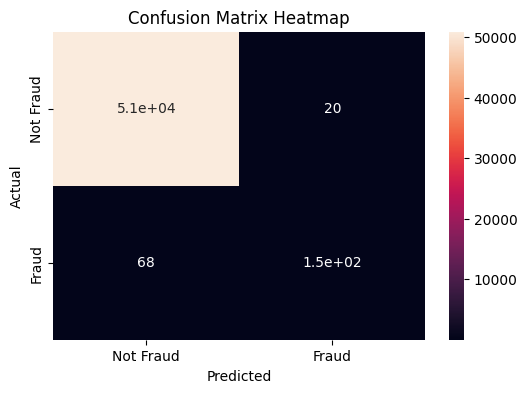

In [15]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [16]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50927
           1       0.88      0.69      0.77       217

    accuracy                           1.00     51144
   macro avg       0.94      0.84      0.89     51144
weighted avg       1.00      1.00      1.00     51144

